In [1]:
import os
os.chdir('..')

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from DataManager.WindTK import WindTKAPI

In [4]:
api = WindTKAPI()

In [32]:
df = api.get_dataframe(t1=(1,1), t2=(12,31))

In [18]:
non_surf_altitudes = [40, 60, 80, 100, 120, 140, 160, 200]

In [7]:
speed_df = []
for i, row in df.iterrows():
    surf_speed = row['wind_speed_10m']
    for alt in non_surf_altitudes:
        col = f"wind_speed_{alt}m"
        speed = row[col]
        speed_df.append([surf_speed, alt, speed])
speed_df = pd.DataFrame(speed_df, columns=['surface_speed','altitude','wind_speed'])

In [8]:
X = speed_df[['surface_speed','altitude']].copy()
y = speed_df['wind_speed']

In [38]:
from sklearn.model_selection import train_test_split, cross_val_score

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

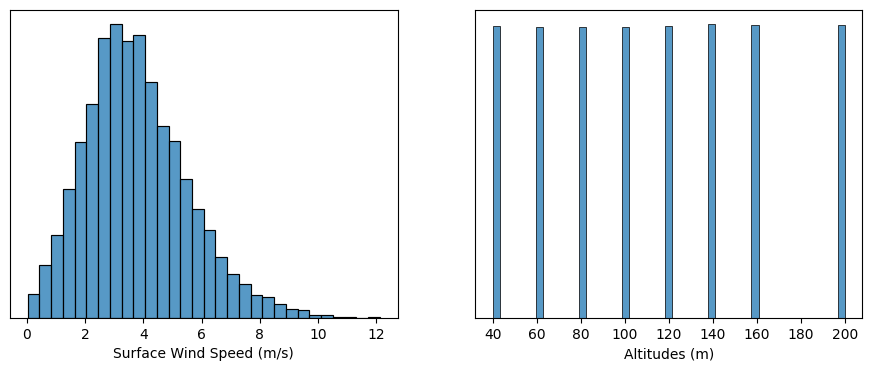

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(11,4))
sns.histplot(X_train['surface_speed'], ax=axes[0], bins=30)
sns.histplot(X_train['altitude'], ax=axes[1])
axes[0].set_xlabel('Surface Wind Speed (m/s)')
axes[1].set_xlabel('Altitudes (m)')
axes[0].set_yticks([])
axes[1].set_yticks([])
axes[0].set_ylabel('')
axes[1].set_ylabel('')
plt.show()

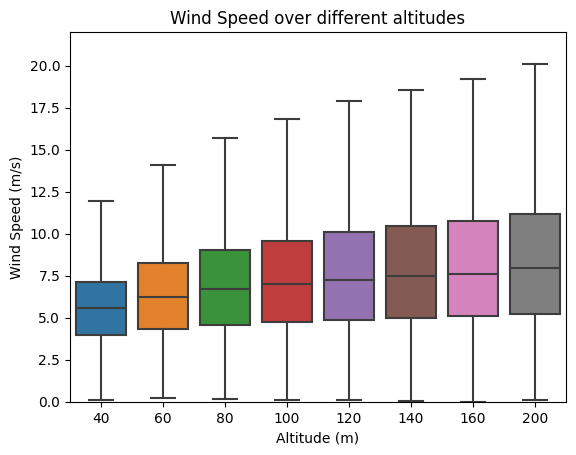

In [12]:
fig, ax = plt.subplots()
sns.boxplot(x=X_train['altitude'], y=y_train, showfliers=False, ax=ax)
ax.set_title('Wind Speed over different altitudes')
ax.set_ylabel('Wind Speed (m/s)')
ax.set_ylim([0,22])
ax.set_xlabel('Altitude (m)')
plt.show()

In [13]:
top_ws = X_train.loc[X_train.altitude == 200].copy()
top_ws['wind_speed'] = y_train[top_ws.index]

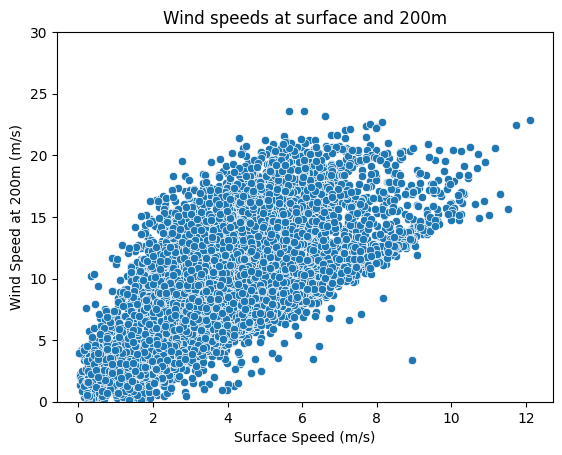

In [14]:
fig, ax = plt.subplots()
sns.scatterplot(x=top_ws['surface_speed'], y=top_ws['wind_speed'])
ax.set_ylim([0, 30])
ax.set_title('Wind speeds at surface and 200m')
ax.set_xlabel('Surface Speed (m/s)')
ax.set_ylabel('Wind Speed at 200m (m/s)')
plt.show()

In [15]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [41]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

# Create the list of regression models with their initializations
model_shortlist = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    xgb.XGBRegressor()
]

In [17]:
for model in model_shortlist:
    name = str(type(model)).split('.')[-1][:-2]
    scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
    scores = [-1 * s for s in scores]
    median = round(np.median(scores), 3)
    mean = round(np.mean(scores),3)
    print(f"{name}: {scores}\nMedian: {median}\nMean: {mean}")

LinearRegression: [2.517952936769968, 2.4315581626626095, 2.587256755758774, 2.667542383441007, 2.665850985249103]
Median: 2.587
Mean: 2.574
Ridge: [2.517952511247807, 2.431558307971503, 2.587256599801837, 2.667542762016771, 2.665851025555043]
Median: 2.587
Mean: 2.574
Lasso: [2.83140024984974, 2.7753555091689934, 2.8983634401735094, 2.9956219152419683, 2.972676744772361]
Median: 2.898
Mean: 2.895
ElasticNet: [2.8198076895831115, 2.762743015354222, 2.8850064319569113, 2.985073245761342, 2.9612448058178513]
Median: 2.885
Mean: 2.883
DecisionTreeRegressor: [2.5583622756255417, 2.47198152027213, 2.6184011122389395, 2.6980440701838084, 2.6985322722004947]
Median: 2.618
Mean: 2.609
RandomForestRegressor: [2.552262705882664, 2.4660203008918935, 2.6124504256369323, 2.6915438204185285, 2.6930934619825937]
Median: 2.612
Mean: 2.603
GradientBoostingRegressor: [2.4637081324359413, 2.371913862213258, 2.5313719133731682, 2.605684088972778, 2.6090681112936225]
Median: 2.531
Mean: 2.516
KNeighborsReg

In [18]:
xgb_params = [{}, {'max_depth':10}, {'max_depth':5}, {'max_depth':15}]

for params in xgb_params:
    xgb_reg = xgb.XGBRegressor(**params)
    scores = cross_val_score(xgb_reg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
    scores = [-1 * s for s in scores]
    print(f"{params} {np.median(scores)} {np.mean(scores)}")

{} 2.527164353006145 2.515075334502016
{'max_depth': 10} 2.5661962019941167 2.5568480743854463
{'max_depth': 5} 2.5219866480472177 2.5084060235120655
{'max_depth': 15} 2.6013947279861656 2.592196489498966


In [19]:
xgb_params = [{}, {'n_estimators':90}, {'max_depth':80}, {'max_depth':120}]

for params in xgb_params:
    xgb_reg = xgb.XGBRegressor(**params)
    scores = cross_val_score(xgb_reg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
    scores = [-1 * s for s in scores]
    print(f"{params} {np.median(scores)} {np.mean(scores)}")

{} 2.527164353006145 2.515075334502016
{'n_estimators': 90} 2.526393329890569 2.513886761016713
{'max_depth': 80} 2.616396936826277 2.6075353047465097
{'max_depth': 120} 2.616396936826277 2.6075353047465097


In [20]:
xgb_reg = xgb.XGBRegressor(max_depth=5, n_estimators=90)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=90, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [21]:
y_pred = xgb_reg.predict(X_test)

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("XGBRegressor Results")
print("MSE : ", mean_squared_error(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred, squared=False))
print("MAE : ", mean_absolute_error(y_test, y_pred))

XGBRegressor Results
MSE :  6.2444914079831415
RMSE:  2.4988980387329014
MAE :  1.8776923299431758


## Detailed Boreas Model

In [9]:
import os
os.chdir('..')

In [10]:
lat, lon = 37.9543963, -91.7831068

In [11]:
from DataManager.WindTK import WindTKAPI
from DataManager.OpenWeather import OpenWeatherAPI

In [12]:
wind_api = WindTKAPI()
ow_api = OpenWeatherAPI()

In [13]:
wind_api.download(lat=lat, lon=lon, year=2013)

WindTK Data saved as CSV successfully.


In [14]:
df = wind_api.get_dataframe(t1=(1,1), t2=(12,31))

In [15]:
from datetime import datetime

WINTSOL = 355

def wint_sol_dist(y, m, d):
    doy = datetime(int(y), int(m), int(d)).timetuple().tm_yday
    if doy >= WINTSOL:
        return doy - WINTSOL
    else:
        return min((365-WINTSOL+doy),(WINTSOL-doy))

df['wint_sol_dist'] = df.apply(lambda row: wint_sol_dist(row.Year, row.Month, row.Day), axis=1)

In [19]:
alt_df = []
for i, row in df.iterrows():
    surf_speed = row['wind_speed_10m']
    temp = row['air_temp_10m']
    wint_sol_dist = row['wint_sol_dist']
    for alt in non_surf_altitudes:
        col = f"wind_speed_{alt}m"
        speed = row[col]
        alt_df.append([surf_speed, temp, wint_sol_dist, alt, speed])
alt_df = pd.DataFrame(alt_df, columns=['surface_speed', 'surface_temp', 'wint_sol_dist', 'altitude', 'wind_speed'])

In [20]:
X = alt_df[['surface_speed', 'surface_temp', 'wint_sol_dist', 'altitude']].copy()
y = alt_df['wind_speed']

In [22]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [42]:
for model in model_shortlist:
    name = str(type(model)).split('.')[-1][:-2]
    scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
    scores = [-1 * s for s in scores]
    median = round(np.median(scores), 3)
    mean = round(np.mean(scores),3)
    print(f"{name}: {scores}\nMedian: {median}\nMean: {mean}")

LinearRegression: [2.493146630258701, 2.410516052171295, 2.569661966427797, 2.6476033170171793, 2.644258557021902]
Median: 2.57
Mean: 2.553
Ridge: [2.4931462662174537, 2.41051627682805, 2.5696616888857045, 2.64760361538185, 2.644258653725895]
Median: 2.57
Mean: 2.553
Lasso: [2.83140024984974, 2.7753555091689934, 2.8983634401735094, 2.9956219152419683, 2.972676744772361]
Median: 2.898
Mean: 2.895
ElasticNet: [2.8198076895831115, 2.762743015354222, 2.8850064319569113, 2.985073245761342, 2.9612448058178513]
Median: 2.885
Mean: 2.883
DecisionTreeRegressor: [1.8627082489935545, 1.7896768297708054, 1.8079966299036558, 2.0389647771157895, 1.9711513558784608]
Median: 1.863
Mean: 1.894
RandomForestRegressor: [1.3892368056368136, 1.294372795387749, 1.5119987405473374, 1.5758186210657403, 1.5643293001935477]
Median: 1.512
Mean: 1.467
GradientBoostingRegressor: [2.288843460582586, 2.19642112967827, 2.3718979008485435, 2.449484504842929, 2.455011006222216]
Median: 2.372
Mean: 2.352
KNeighborsRegres

In [43]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [40]:
from xgboost import XGBRegressor
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [37]:
import os
import sys
import pickle
import psutil

pid = os.getpid()
process = psutil.Process(pid)

def memusage():
    memory_info = process.memory_info()
    print(f"Memory Usage: {memory_info.rss / 1024 ** 2} MB / {memory_info.rss / 1024 ** 3} GB")

def sizeof(s):
    p = pickle.dumps(s)
    print(f"Size: {round(sys.getsizeof(p) / 1024**2,3)} MB")

In [46]:
sizeof(dt_reg)

Size: 13.348 MB


In [45]:
from sklearn.model_selection import GridSearchCV

rf_params = {
    'n_estimators': [80, 100, 120],
    'max_depth': [30, 40, 50]
}

rf_reg = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf_reg, 
                           param_grid=rf_params, 
                           cv=5, 
                           scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)


KeyboardInterrupt



In [24]:
rf_reg.fit(X_train, y_train)

NameError: name 'rf_reg' is not defined

In [47]:
y_pred = dt_reg.predict(X_test)

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("XGBRegressor Results")
print("MSE : ", mean_squared_error(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred, squared=False))
print("MAE : ", mean_absolute_error(y_test, y_pred))

XGBRegressor Results
MSE :  3.149843092715468
RMSE:  1.7747797307596984
MAE :  0.6992203553082192


## Boreas Implementation

In [49]:
from DataManager.OpenWeather import OpenWeatherAPI

In [50]:
ow_api = OpenWeatherAPI()

In [51]:
ow_api.download(lat, lon)

Weather JSON Data sucessfully downloaded.


In [66]:
df

,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,cloudiness,speed,deg,gust,description,weather,weather_id,datetime,hour,day
0,86.738,95.972,81.968,86.738,1016,1016,976,68,33,2.87,205,5.17,scattered clouds,Clouds,802,1692828000,0,0
1,82.364,86.216,78.980,82.364,1015,1015,976,66,67,2.99,194,4.36,broken clouds,Clouds,803,1692838800,3,0
2,74.552,75.146,74.552,74.552,1015,1015,976,73,75,2.97,201,5.72,broken clouds,Clouds,803,1692849600,6,0
3,74.210,74.858,74.210,74.210,1015,1015,976,75,64,3.13,203,8.26,broken clouds,Clouds,803,1692860400,9,0
4,89.852,93.884,89.852,89.852,1016,1016,978,49,34,4.19,235,6.63,scattered clouds,Clouds,802,1692871200,12,0
5,99.860,103.910,99.860,99.860,1014,1014,977,33,42,3.32,255,3.56,scattered clouds,Clouds,802,1692882000,15,0
6,103.280,104.126,103.280,103.280,1012,1012,975,24,98,2.13,231,3.86,overcast clouds,Clouds,804,1692892800,18,0
7,91.328,93.488,91.328,91.328,1011,1011,973,42,98,2.92,207,5.84,overcast clouds,Clouds,804,1692903600,21,0
8,77.972,78.530,77.972,77.972,1013,1013,974,65,13,2.89,175,4.57,light rain,Rain,500,1692914400,0,1
9,78.656,78.674,78.656,78.656,1013,1013,975,52,18,2.59,204,4.97,few clouds,Clouds,801,1692925200,3,1


In [ ]:
def ow_wint_sol_dist(dt):
    t = datetime.fromtimestamp(dt)
    doy = t.timetuple().tm_yday
    

In [79]:
list(df.datetime.map(dt_to_wsd))

[120,
 120,
 120,
 119,
 119,
 119,
 119,
 119,
 119,
 119,
 119,
 118,
 118,
 118,
 118,
 118,
 118,
 118,
 118,
 117,
 117,
 117,
 117,
 117,
 117,
 117,
 117,
 116,
 116,
 116,
 116,
 116,
 116,
 116,
 116,
 115,
 115,
 115,
 115,
 115]

In [77]:
WINT_SOL = 355
def wint_sol_dist(y, m, d):
        doy = datetime(int(y), int(m), int(d)).timetuple().tm_yday
        if doy >= WINT_SOL:
            return doy - WINT_SOL
        else:
            return min((365 - WINT_SOL + doy), (WINT_SOL - doy))
        
def dt_to_wsd(dt):
    dt = datetime.fromtimestamp(dt)
    return wint_sol_dist(dt.year, dt.month, dt.day)

In [55]:
list(df.speed.values)

[2.87,
 2.99,
 2.97,
 3.13,
 4.19,
 3.32,
 2.13,
 2.92,
 2.89,
 2.59,
 2.98,
 3.06,
 3.21,
 2.27,
 1.96,
 2.07,
 2.88,
 3.1,
 2.41,
 0.61,
 1.97,
 2.76,
 4.74,
 3.18,
 1.01,
 2.13,
 2.52,
 2.56,
 3.03,
 1.22,
 1.05,
 3.26,
 2.7,
 2.27,
 2.12,
 2.23,
 2.47,
 2.45,
 1.45,
 1.26]